In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)

import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# import the data

train = pd.read_csv('ml_case_training_data.csv',parse_dates=['date_activ','date_end','date_modif_prod','date_renewal'])
hist = pd.read_csv('ml_case_training_hist_data.csv')
churn_data = pd.read_csv('ml_case_training_output.csv')

In [3]:
# find total price of energy and power per user for the period

hist['total_power_price'] = hist['price_p1_fix']+ hist['price_p2_fix'] + hist['price_p3_fix']
hist['total_energy_price'] = hist['price_p1_var']+ hist['price_p2_var'] + hist['price_p3_var']

In [6]:
# group transactions by user

cust_hist = hist.groupby('id').sum()
cust_hist = cust_hist.reset_index()
cust_hist[['id','total_power_price','total_energy_price']].head()

,id,total_power_price,total_energy_price
0,0002203ffbb812588b632b9e628cc38d,976.841578,3.615510
1,0004351ebdd665e6ee664792efc4fd13,532.625404,1.757118
2,0010bcc39e42b3c2131ed2ce55246e3c,543.836520,2.178702
3,0010ee3855fdea87602a5b7aba8e42de,975.538248,3.432978
4,00114d74e963e47177db89bc70108537,531.203164,1.775110


In [7]:
# the merge

data = pd.merge(train,churn_data)
data = pd.merge(data,cust_hist[['id','total_power_price','total_energy_price']])

### Cleaning the Data

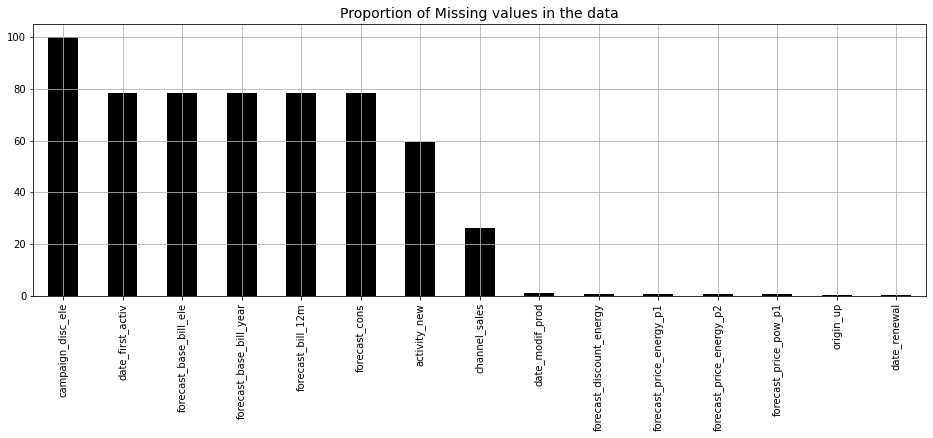

In [8]:
# Missing values

(data.isnull().mean()*100).sort_values(ascending=False)[:15].plot(kind='bar', figsize=(16,5), color='black')
plt.title('Proportion of Missing values in the data', fontsize=14)
plt.grid()
plt.show()

In [9]:
# Droping the missing columns with over 50% missing and
# Droping the rows from columns with less that 2% missing values

for feature in data.columns:
    if data[feature].isnull().mean() > 0.5:
        data.drop(feature, axis=1, inplace=True)
    
data.dropna(inplace=True, subset=['forecast_price_energy_p1','date_modif_prod','margin_gross_pow_ele','origin_up','date_renewal','net_margin'])

In [11]:
# Replace missing values in sales channel

data['channel_sales'] = data['channel_sales'].replace(np.NaN, 'missing_channel_sales')

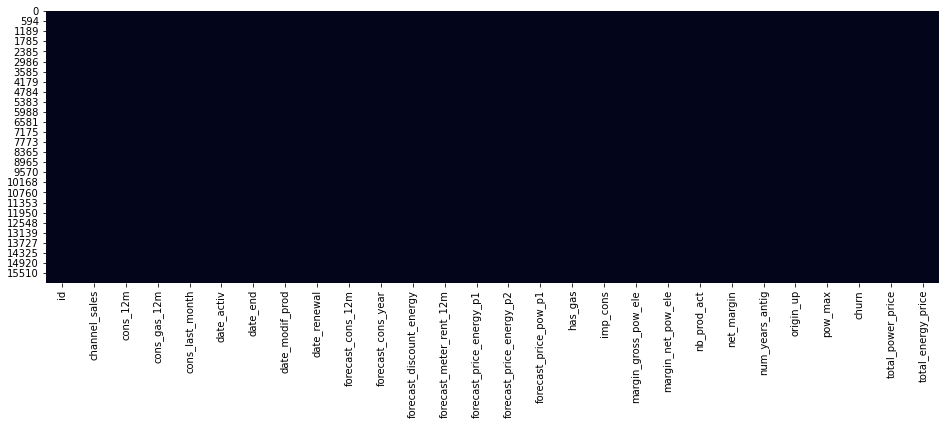

In [12]:
# Show if there is still any missing value in the data

plt.figure(figsize=(16,5))
sns.heatmap(data= data.isnull(),cbar=False)
plt.show()

### Historical flow of prices from January - Dec 2015

In [13]:
#  convert the price date to datetime and set as index

hist['price_date'] = pd.to_datetime(hist.price_date)   # converting to datetime
hist = hist.set_index('price_date')  # setting as index

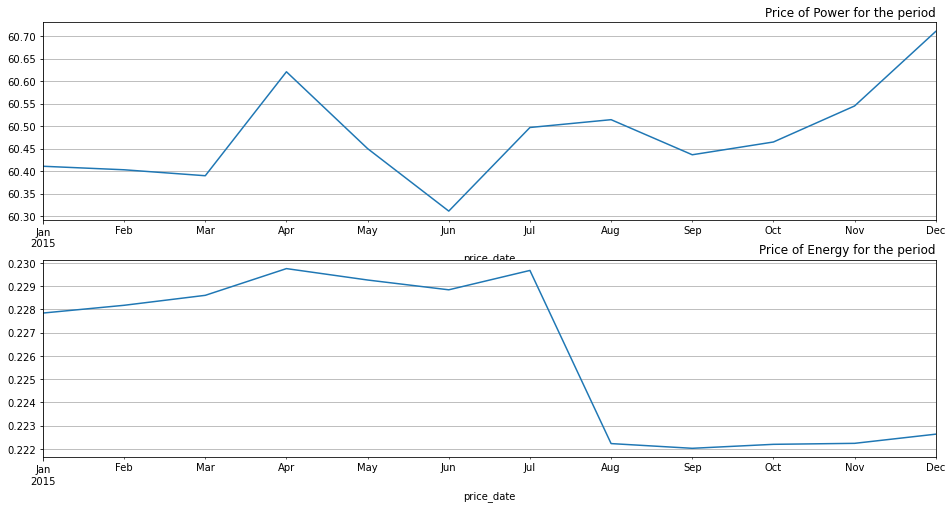

In [15]:
plt.figure(figsize=(16,8))

#Plot 1

plt.subplot(2,1,1)
hist.total_power_price.resample('M').mean().plot(scalex=False)
plt.title('Price of Power for the period', loc='right')
plt.grid()

#Plot 2

plt.subplot(2,1,2)
hist.total_energy_price.resample('M').mean().plot()
plt.title('Price of Energy for the period',loc='right')

plt.grid()
plt.show()

#### Observation

Price of energy is oserved to have fallen drasticaling in the summer

### Exploratory Data Analysis

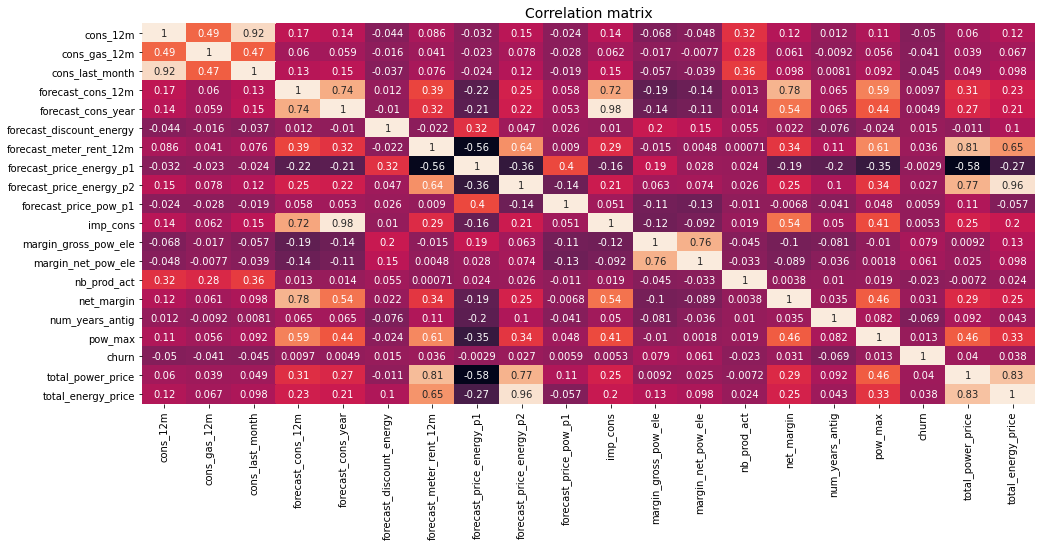

In [16]:
# showing multicolinearity in the data

plt.figure(figsize=(16,7))
sns.heatmap(data.corr(), annot=True, cbar=False)
plt.title('Correlation matrix', fontsize=14)
plt.show()

#### Churn

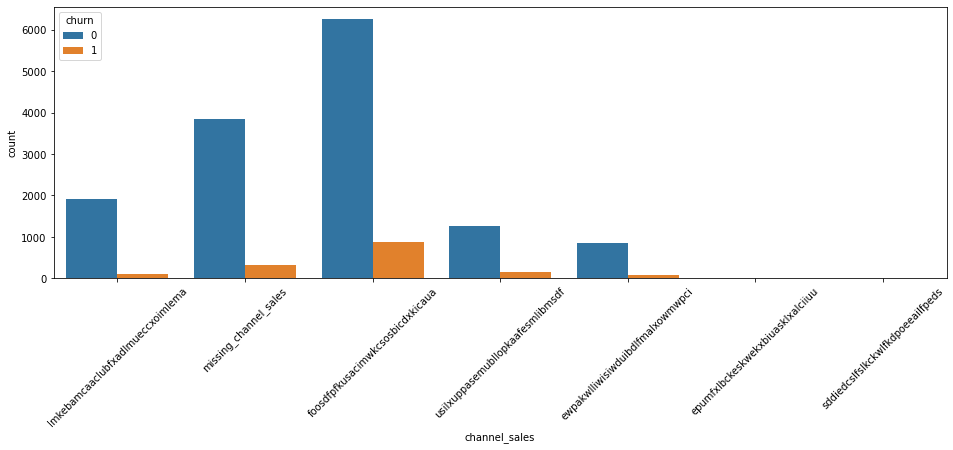

In [23]:

plt.figure(figsize=(16,5))

sns.countplot(x='channel_sales', data=data, hue='churn')
plt.xticks(rotation=45)
plt.show()

In [36]:
#  treating the outliers

Q1=data['margin_gross_pow_ele'].quantile(0.25)
Q3=data['margin_gross_pow_ele'].quantile(0.75)

IQR= Q3-Q1

Lower_Whisker = Q1-1.5 *IQR
Upper_Whisker = Q3+1.5*IQR

data = data[(data['margin_gross_pow_ele']< Upper_Whisker) & (data['margin_gross_pow_ele']> Lower_Whisker)]

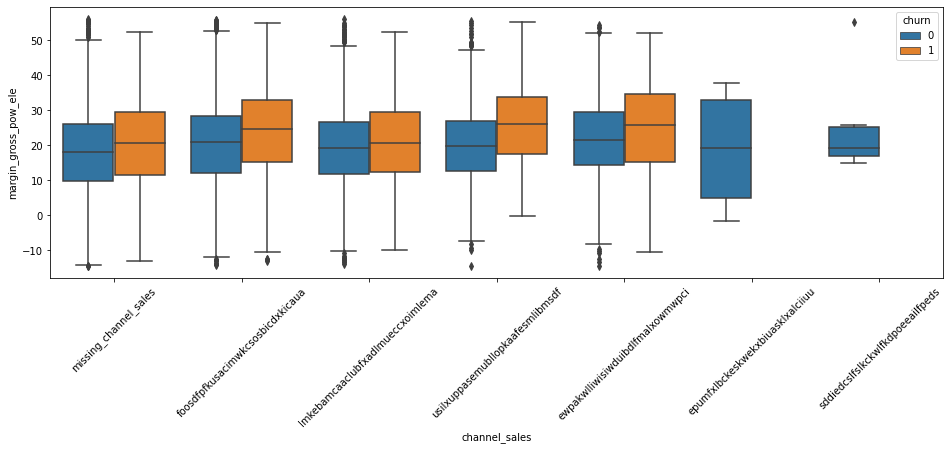

In [41]:
plt.figure(figsize=(16,5))
sns.boxplot(x='channel_sales', y='margin_gross_pow_ele', data=data, hue='churn')
plt.xticks(rotation=45)
plt.show()

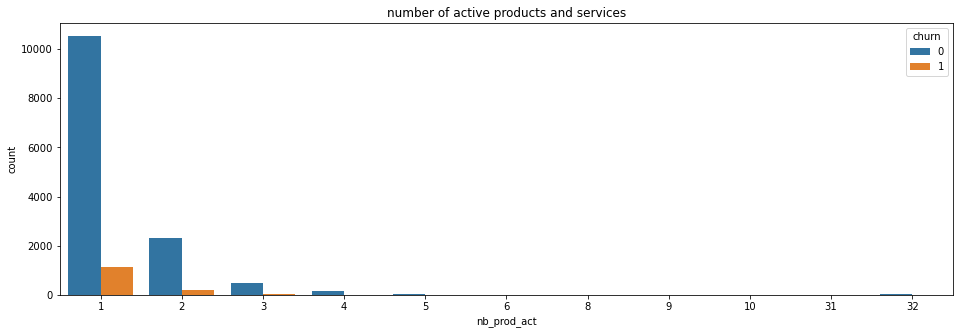

In [58]:
plt.figure(figsize=(16,5))
sns.countplot(data=data, x = 'nb_prod_act', hue='churn')
# sns.histplot(data=data, x = 'nb_prod_act', hue='churn', multiple="stack")
plt.title('Number of active products and services')

plt.show()

#### Observation

Customers with fewer packages have high probability of churning